In [1]:
import pandas as pd
import numpy as np
import os
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
import datetime
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, date


import warnings
warnings.filterwarnings("ignore")
old_data_folder = '/Users/simonneumeyer/Dropbox/DO-FILES/data/'


Bad key "text.kerning_factor" on line 4 in
/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Load and process data

In [2]:
df_master = pd.read_stata('../../data/output/firm_year_level.dta')

In [3]:
df_master = df_master[df_master.active=='Active firm in year t']
df_master = df_master[df_master.period==2015]
df_master = df_master[df_master.main_dataset=='Tax/Credit Registry']

df_master = df_master[df_master.has_loan==1]

In [4]:
df_master.main_dataset.value_counts()

Tax/Credit Registry                                       9282
Created to add 0s to outcome variables of exited firms       0
Name: main_dataset, dtype: int64

In [5]:
df_master.active.value_counts()

Active firm in year t    9282
Closed firm in year t       0
Name: active, dtype: int64

In [6]:
df_master.credit_treatment_status.value_counts()

Loan without KCGF    8739
Loan with KCGF        543
No loan, no KCGF        0
Name: credit_treatment_status, dtype: int64

In [7]:
#df_master

In [8]:
df_master['age_squared'] = df_master.age ** 2

df_master['num_loans_squared'] = df_master.num_loans ** 2
df_master['lag1_num_loans_squared'] = df_master.lag1_num_loans ** 2
df_master['lag2_num_loans_squared'] = df_master.lag2_num_loans ** 2

df_master['productivity_squared'] = df_master.productivity ** 2
df_master['lag1_productivity_squared'] = df_master.lag1_productivity ** 2
df_master['lag2_productivity_squared'] = df_master.lag2_productivity ** 2

df_master['employees_tx_squared'] = df_master.employees_tx ** 2
df_master['lag1_employees_tx_squared'] = df_master.lag1_employees_tx ** 2
df_master['lag2_employees_tx_squared'] = df_master.lag2_employees_tx ** 2

df_master['wages_worker_squared'] = df_master.wages_worker ** 2
df_master['lag1_wages_worker_squared'] = df_master.lag1_wages_worker ** 2
df_master['lag2_wages_worker_squared'] = df_master.lag2_wages_worker ** 2

In [9]:
#df_master.econ_sector.isna().sum()

In [10]:
#df_master.dropna()

In [11]:
# if we choose to drop missing values rather than imputing them
df_master = df_master.dropna(subset=['municipalityid_tx', 'econ_sector', 'size_tx'])

In [12]:
#df_master[['period', 'municipalityid_tx']] = df_master[['period', 'municipalityid_tx']].astype(str)

In [13]:
df_dummies = pd.get_dummies(df_master[['econ_sector',
                                       #'size_tx',
                                       'municipalityid_tx']])

In [14]:
dep_var = 'treated_kcgf'
indep_var = 'credit_treatment_status'
covars = ['age', 'age_squared', 
          'productivity', 'productivity_squared', 'lag1_productivity', 'lag1_productivity_squared',
          'lag2_productivity', 'lag2_productivity_squared', 
          'wages_worker', 'wages_worker_squared', 'lag1_wages_worker', 'lag1_wages_worker_squared', 
          'lag2_wages_worker', 'lag2_wages_worker_squared', 
          'num_loans', 'num_loans_squared', 'lag1_num_loans', 'lag1_num_loans_squared', 
          'lag2_num_loans', 'lag2_num_loans_squared',
          'export_tx', 'import_tx'] + df_dummies.columns.tolist()


In [15]:
df_master = pd.concat([df_master, df_dummies], axis=1)

In [16]:
df_master = df_master.reset_index(drop=True)

In [17]:
df_master.shape

(9277, 229)

In [18]:
df_master['has_loan'].value_counts(dropna=False)

1.0    9277
Name: has_loan, dtype: int64

# 1st step lasso: (replicated Vivian's results)

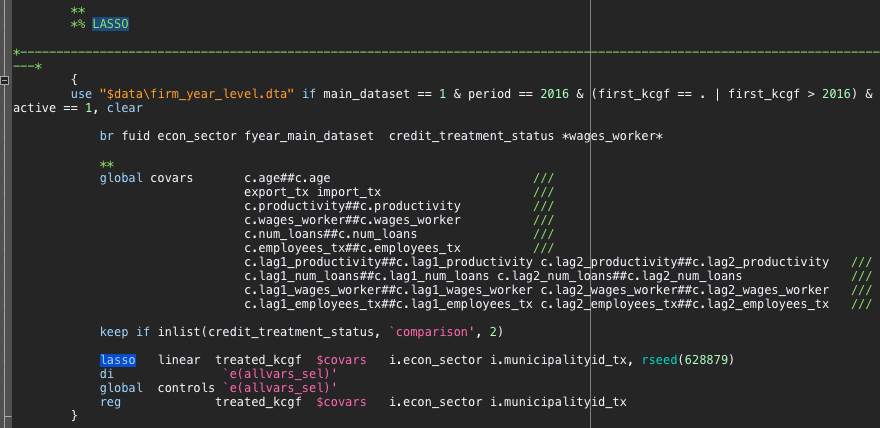

## First step: Select variables that predict dependent variable

In [19]:
y = df_master[dep_var]
X = df_master[covars]

In [20]:
X_dropna = X.dropna() # stata way
y_dropna = y[X_dropna.index]

#X_fillna = X.fillna(X.interpolate()) # alternative way


In [21]:
#X_dropna

In [22]:
%%time
from sklearn import linear_model

alphas = np.geomspace(0.15, 0.00001, 1000)
reg = linear_model.LassoCV(cv=10, 
                           alphas=alphas, 
                           n_alphas=1000, 
                           random_state=4, 
                           verbose=False, 
                           max_iter=10000).fit(X_dropna, y_dropna)


CPU times: user 25.4 s, sys: 314 ms, total: 25.7 s
Wall time: 24.3 s


In [23]:
reg.score(X_dropna, y_dropna)


0.009648027502030865

In [24]:
# refit:
lassocv_alpha = reg.alpha_
clf = linear_model.Lasso(alpha=lassocv_alpha) # selected alpha = 0.0006449
clf.fit(X_dropna, y_dropna)
clf.score(X_dropna, y_dropna)

0.009648027502030865

In [25]:
selected_vars = np.array(X_dropna.columns)[clf.coef_!=0].tolist()

In [26]:
#len(selected_vars)

In [27]:
coefficients = pd.DataFrame()
coefficients['variable'] = X_dropna.columns
coefficients['coefficient'] = clf.coef_
coefficients['coefficient'] = coefficients.coefficient.round(6)
coefficients = coefficients.set_index('variable')

In [28]:
coefficients

,coefficient
variable,
age,-0.000000
age_squared,-0.000096
productivity,0.000002
productivity_squared,-0.000000
lag1_productivity,0.000000
lag1_productivity_squared,-0.000000
lag2_productivity,-0.000001
lag2_productivity_squared,0.000000
wages_worker,0.000025


## 2nd step: Select variables that predict independent variable

In [23]:
y = df_master[indep_var]
X = df_master[covars]

In [24]:
X_dropna = X.dropna() # stata way
y_dropna = y[X_dropna.index]


In [25]:
#y

In [26]:
X[y=='No loan, no KCGF']

,age,age_squared,lag_productivity,lag_productivity_squared,lag_wages_worker,lag_wages_worker_squared,lag_num_loans,lag_num_loans_squared,export_tx,import_tx,size_tx_Micro (0-9),size_tx_Small (10-49),size_tx_Medium (50-249),size_tx_Large (250+),period_2010.0,period_2011.0,period_2012.0,period_2013.0,period_2014.0,period_2015.0,period_2016.0,period_2017.0,period_2018.0,econ_sector_Administrative services,econ_sector_Agriculture,econ_sector_Arts & entertainment,econ_sector_Chemicals,econ_sector_Coke & ref. petroleum,econ_sector_Computer & electronics,econ_sector_Construction,econ_sector_Education,econ_sector_Electrical equipment,econ_sector_Electricity & gas,econ_sector_Finance,econ_sector_Food & beverages,econ_sector_Furniture & other,econ_sector_Health,econ_sector_Hotels & restaurants,econ_sector_IT,econ_sector_Legal & accounting,econ_sector_Machinery and equipment,econ_sector_Marketing & other,econ_sector_Media,econ_sector_Metal products,econ_sector_Mining,econ_sector_Other services,econ_sector_Pharmaceuticals,econ_sector_Public administration,econ_sector_Real estate,econ_sector_Rubber & plastics,econ_sector_Scientific R&D,econ_sector_Social work,econ_sector_Telecommunications,econ_sector_Textiles & apparel,econ_sector_Transport equipment,econ_sector_Transportation & storage,econ_sector_Water & sewerage,econ_sector_Wholesale & retail,econ_sector_Wood & paper prod.,municipalityid_tx_1.0,municipalityid_tx_10.0,municipalityid_tx_11.0,municipalityid_tx_12.0,municipalityid_tx_13.0,municipalityid_tx_14.0,municipalityid_tx_15.0,municipalityid_tx_16.0,municipalityid_tx_17.0,municipalityid_tx_18.0,municipalityid_tx_19.0,municipalityid_tx_2.0,municipalityid_tx_20.0,municipalityid_tx_21.0,municipalityid_tx_22.0,municipalityid_tx_23.0,municipalityid_tx_24.0,municipalityid_tx_25.0,municipalityid_tx_26.0,municipalityid_tx_27.0,municipalityid_tx_28.0,municipalityid_tx_29.0,municipalityid_tx_3.0,municipalityid_tx_30.0,municipalityid_tx_31.0,municipalityid_tx_33.0,municipalityid_tx_34.0,municipalityid_tx_38.0,municipalityid_tx_4.0,municipalityid_tx_5.0,municipalityid_tx_6.0,municipalityid_tx_7.0,municipalityid_tx_8.0,municipalityid_tx_9.0
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328198,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
328199,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [29]:
# Out of observations with no loan no KCGF: How many missing values?
X[y=='No loan, no KCGF'].notna().sum()

age                                     171647
age_squared                             171647
lag_productivity                         59465
lag_productivity_squared                 59465
lag_wages_worker                         65529
lag_wages_worker_squared                 65529
lag_num_loans                                0
lag_num_loans_squared                        0
export_tx                               171647
import_tx                               171647
size_tx_Micro (0-9)                     171647
size_tx_Small (10-49)                   171647
size_tx_Medium (50-249)                 171647
size_tx_Large (250+)                    171647
period_2010.0                           171647
period_2011.0                           171647
period_2012.0                           171647
period_2013.0                           171647
period_2014.0                           171647
period_2015.0                           171647
period_2016.0                           171647
period_2017.0

In [30]:
y_dropna.value_counts()

Loan without KCGF    31325
Loan with KCGF        2410
No loan, no KCGF         0
Name: credit_treatment_status, dtype: int64

In [37]:
y_multi = pd.get_dummies(y_dropna)

In [38]:
#y_multi.loc[y_multi['Loan without KCGF']==1, 'Loan with KCGF'] = np.nan
#y_multi.loc[y_multi['Loan with KCGF']==1, 'Loan without KCGF'] = np.nan

In [39]:
y1 = y_multi['No loan, no KCGF']
y2 = y_multi['Loan without KCGF']
y3 = y_multi['Loan with KCGF']

In [40]:
y1.value_counts()

0    33735
Name: No loan, no KCGF, dtype: int64

In [41]:
y_dropna[y_dropna=='No loan, no KCGF']

Series([], Name: credit_treatment_status, dtype: category
Categories (3, object): [No loan, no KCGF < Loan without KCGF < Loan with KCGF])

In [42]:
%%time
from sklearn import linear_model

selected_vars_step_2 = []
scores = []
for y in [y2, y3]:
    alphas = np.geomspace(0.15, 0.00001, 1000)
    reg_2 = linear_model.LassoCV(cv=10, alphas=alphas, n_alphas=1000, random_state=4, 
                                 verbose=False, max_iter=10000).fit(X_dropna, y)
    
    #print(f'Score: {reg_2.score(X_dropna, y)}')
    # refit:
    lassocv_alpha = reg_2.alpha_
    clf = linear_model.Lasso(alpha=lassocv_alpha) # selected alpha = 0.0006449
    clf.fit(X_dropna, y)
    print(f'Score: {clf.score(X_dropna, y)}')
    
    vars_ = np.array(X_dropna.columns)[reg_2.coef_!=0].tolist()
    selected_vars_step_2 = list(set.union(set(selected_vars_step_2), set(vars_)))
    scores.append(clf.score(X_dropna, y))
    


Score: 0.022309890545942235
Score: 0.02230989647067505
CPU times: user 3min 51s, sys: 10.6 s, total: 4min 2s
Wall time: 3min 55s


In [102]:
len(selected_vars_step_2)

45

In [103]:
len(selected_vars)

49

In [106]:
overall_vars = list(set(selected_vars + selected_vars_step_2))

In [48]:
len(overall_vars)

NameError: name 'overall_vars' is not defined

In [107]:
X.shape

(325551, 93)

In [26]:
#X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25, random_state=0)
#
#alphas = np.logspace(-4, -1, 10)
#scores = np.empty_like(alphas)
#for i,a in enumerate(alphas):
#    lasso = linear_model.Lasso()
#    lasso.set_params(alpha=a)
#    lasso.fit(X_train, y_train)
#    scores[i] = lasso.score(X_test, y_test)
#    print(a, lasso.coef_)
#    
#lassocv = linear_model.LassoCV()
#lassocv.fit(X, y)
#lassocv_score = lassocv.score(X, y)
#lassocv_alpha = lassocv.alpha_
#print('CV', lassocv.coef_)
#
#plt.plot(alphas, scores, '-ko')
#plt.axhline(lassocv_score, color='b', ls='--')
#plt.axvline(lassocv_alpha, color='b', ls='--')
#plt.xlabel(r'$\alpha$')
#plt.ylabel('Score')
#plt.xscale('log')
#sns.despine(offset=15)

# Ridge regression

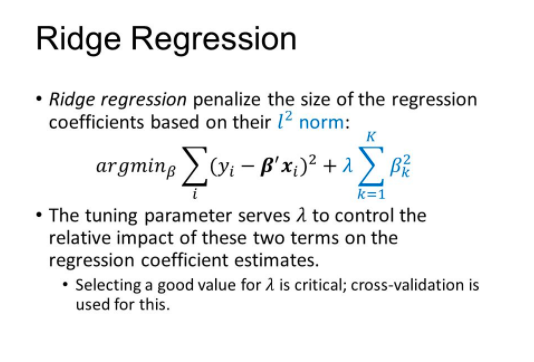

In [45]:
alphas = np.geomspace(100, 1, 100)

In [46]:
%%time
reg = linear_model.RidgeCV(cv=10, alphas=alphas).fit(X_dropna, y_dropna)

ValueError: could not convert string to float: 'Loan without KCGF'

In [47]:
r2 = reg.score(X_dropna, y_dropna)
print(f'R-squared: {r2}')

ValueError: could not convert string to float: 'Loan without KCGF'

In [63]:
reg.alpha_

65.79332246575679

In [77]:
np.array(X_dropna.columns)[reg.coef_==0].tolist()

['period_2010.0']

R2 score very similar, less variables dropped as compared to Lasso. <br>
Problem with 2nd step: If we drop NAs similarly as in 1st step, we end up with 0 observations with label "No loans, no KCGF"